# TODO: add more comments and explanations
Also requirements and general clean up.

In [1]:
# to install the requirements you can uncomment and run 
#!pip install -r requirements.txt

In [2]:
# Imports
import glob, sys, os
import numpy as np
# Plotting Stuff
from matplotlib import pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.CMS)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
mpl.rcParams['font.size'] = 12
# Various utils
import uproot
import torch
from torch.utils.data import DataLoader
from modeloss.pytorch import MoDeLoss
from util.loss import MSE, DiscoLoss
from util.model import Model, ProgressBar, Logger
from util.utils import DataSet, swish, get_class_weights, find_threshold
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Introduction
In this project we will investigate LHC data from 8 TeV collisions. Please see the ``Vqq`` notebook for a good introduction to the physical process we're intrested in looking at and also a simplified version for what we are about to do here (tagging resonances using simple physically motivated cuts on a single variable vs. using a NN.)

# Loading data & Auxiliary functions

Now is a good time to look at the data. Lets take a look at the differen samples we have. The data can be downloaded from this link [here (3 GB)](https://www.dropbox.com/s/bcyab2lljie72aj/data.tgz?dl=0).
You can just uncoment and run the cell below.

In [3]:
# !wget https://www.dropbox.com/s/bcyab2lljie72aj/data.tgz
# !tar -xvf data.tgz

In [4]:
def selection(iData):
    """
    We will want the neural network to do most of the work here so this selection should be as simple as possible. Returns a boolean array
    for the events passing the selection.

    Parameters
    ----------
    iData : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events of interest.
        
    returns allcuts (type=Array) 
    """
    #lets apply a trigger selection
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
    #Now lets require the jet pt to be above a threshold
    jetpt = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
    #Lets apply both jetpt and trigger at the same time
    #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
    allcuts = np.logical_and.reduce([trigger, jetpt])
    return allcuts

In [5]:
#Now lets look at the data. Our data sample is the JetHT dataset.
#What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data = uproot.open("data/JetHT_s.root")["Tree"]
#In addition to above we have Monte Carlo Simulation of many processes
#Some of these process are well modelled in simulation and some of them are not
#Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq = uproot.open("data/WQQ_s.root")["Tree"]
#Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq = uproot.open("data/ZQQ_s.root")["Tree"]
#Unfortunately the samples I made above a long time ago are very small.
#To train NNs and make nice plots we will use larger samples produced at a different collision energy
#qq=>W=>qq at 13TeV collision energy
wqq13 = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
zqq13 = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]
qcd = uproot.open("data/QCD_s.root")["Tree"]
ggh = uproot.open("data/ggH.root")["Tree"]
tt = uproot.open("data/TT.root")["Tree"]
ww = uproot.open("data/WW.root")["Tree"]
wz = uproot.open("data/WZ.root")["Tree"]
zz = uproot.open("data/ZZ.root")["Tree"]
# Select a subset of interest
datasel = selection(data)
wsel = selection(wqq13)
zsel = selection(zqq13)
qcdsel = selection(qcd)
wwsel = selection(ww)
zzsel = selection(zz)
ttsel = selection(tt)
wzsel = selection(wz)
gghsel = selection(ggh)

print("All data loaded. Available features:")
print(*data.keys(), sep=" | ")

All data loaded. Available features:
sample | run | lumi | event | trigger | hltmatch | puweight | npu | npuPlusOne | npuMinusOne | nvtx | metFiltersWord | scale1fb | rho | metRaw | metRawPhi | met | metphi | tkmet | tkmetphi | mvamet | mvametphi | puppet | puppetphi | mt | rawmt | tkmt | mvamt | puppetmt | metSig | mvaMetSig | njets | nbtags | nfwd | mindphi | j0_pt | j0_eta | j0_phi | j1_pt | j1_eta | j1_phi | j2_pt | j2_eta | j2_phi | j0_mass | j0_csv | j0_qgid | j0_chf | j0_nhf | j0_emf | j0_dphi | j1_mass | j1_csv | j1_qgid | j1_chf | j1_nhf | j1_emf | j1_dphi | j2_mass | j2_csv | j2_qgid | j2_chf | j2_nhf | j2_emf | j2_dphi | dj0_pt | dj0_mass | dj0_phi | dj0_y | dj0_qgid | dj0_csv | dj0_jdphi | nvjet | vjet0_pt | vjet0_eta | vjet0_phi | vjet0_mass | vjet0_csv | vjet0_flavor | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_msd0 | vjet0_msd1 | vjet0_mprune | vjet0_mtrim | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_qgid | vjet0_sj2_qgid | vjet0_sj1_q | vjet0_sj2_q | vjet0_

Our goal will be to use a neural network to discriminate between jets from a boosted resonance form a general QCD background.
Before we do this, we have to quickly go over how we weight our simulation. We apply three weights. The weights can be written out as 
\begin{eqnarray}
w_{tot} & = & \rm{total data}\times\sigma\times w_{PU}
\end{eqnarray}
The total data is defined as the total amount data in our sample. To compute this we quote our data in units of $fb^{-1}$. This is a "femto-barn" where a barn is $10^{-28}m^{2}$, a volume of area that rumour has it Enrico Fermi claimed was as big as a barn.  Our next unit is the cross section,$\sigma$, this is the interaction cross section in units of $fb$ so that it cancels with our total data "luminosity". Lastly, we apply a pileup weight,$w_{PU}$ to match the simulated beam intensity. This has an effect at modifying the simulation in a certain way.Now we will define various utility functions that we will need to make accurate histograms with the correct weights.

In [6]:
def integral(iData, iWeights):
    """
    This computs the integral of weighted events assuming a selection given by the function "selection(_)"". We will use this function
    to compute the right scaling factors for the histograms.

    Parameters
    ----------
    iData : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events of interest.
        
    iWeights : list
        This list has a specific format (see below).
        
    returns allcuts (type=Array) 
    """
    #perform a selection on the data
    mask_sel = selection(iData)
    #now iterate over the weights note the weights are in the format of [number,variable name 1, variable name 2,...]
    weight = iWeights[0]
    for i0 in range(1, len(iWeights)):
        weightarr = iData.arrays(
            iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        #multiply the weights
        weight = weight * weightarr
    #now take the integral and return it
    return np.sum(weight)


def scale(iData8TeV, iData13TeV, iWeights):
    """
    This function gives the right scaling factor (S) such that when first dataset (iData13TeV) is multiplied by 6, it has the same area as a second dataset (iData8TeV.) We will use this function
    to compute the right scaling factors for the histograms.

    Parameters
    ----------
    iData8TeV : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events to be scaled to.
        
    iData8TeV : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events to be rescaled.
    
    iWeights : list
        This list has a specific format (see below).
        
    returns Scale (float) 
    """
    int_8TeV = integral(iData8TeV, iWeights)
    int_13TeV = integral(iData13TeV, iWeights)
    S = int_8TeV / int_13TeV
    print("Scale:", S, int_8TeV, int_13TeV)
    return S


def get_weights(weights, iData, sel):
    """
    This function gives the right scaling factor (S) such that when first dataset (iData13TeV) is multiplied by 6, it has the same area as a second dataset (iData8TeV.) We will use this function
    to compute the right scaling factors for the histograms.

    Parameters
    ----------
    iData8TeV : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events whose weights we are interested in finding.
        
    sel : Array
        Boolean array for the selection.
    
    iWeights : Array
        numpy array of the weights.
        
    returns weight (Array) 
    """
    weight = weights[0]
    for i in range(1, len(weights)):
        weight *= iData.arrays(weights[i], library="np")[weights[i]][sel]
    return weight

Now we are ready to make our first neural network! Below is a simple 4 layer fully-connected netweork (FCN.) This architecture was chosen because it works pretty well for this type of data but feel free to play around with it and see if you can get better performance. As you will see below, we conveniently define a ``Model`` wrapper class that takes care of looping, logging etc. The code is in util/model.py if you want to check it out/ make modifications. This class is based on pytorch-lightning which offers a nice framework for doing vairous experiments with different hyperparamters. The ``Logger`` object creates a folder with all your experiments that you can visualize using tensorboard with the command ``ternsorboard --logdir path/to/your/directory``.

In [7]:
class MLP(torch.nn.Module):  # Model from utils
    def __init__(self,
                 input_size=10,
                 out_channels=1,
                 readout_activation=None,
                 name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 64, bias=False)
        self.linear1 = torch.nn.Linear(
            64,
            64,
        )
        self.linear2 = torch.nn.Linear(64, 64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64, out_channels)
        # Defaults
        self.out_channels = out_channels
        self.readout_activation = readout_activation
        self.yhat_val = None
        self.yhat = None
        self.name = name

    def forward(self, x):
        x = swish(self.linear(x))
        x = self.batchnorm(x)
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = self.out(x)
        if self.readout_activation is not None:
            x = self.readout_activation(x)
        return x

### Selecting some features
Now we will select some features to feed our FCN. We will use various fat jet features (features that start with vjet0.)

In [8]:
# Get features
def keep_key(key):
    kws = [
        "gen", "mass", "msd0", "msd1", "flavor", "mprune", "mtrim", "trig",
        "qgid", "iso", "pt", "eta", "phi"
    ] 
    for kw in kws:
        if kw in key: return False
    return True


keys = []  #keys = ["vjet0_msd0"]
keys += [
    key for key in qcd.keys() if key.startswith("vjet0") and keep_key(key)
]
#keys += ["trigger", "puweight", "nvtx", "rho", "metRaw", "metRawPhi", "met", "mvamet", "puppet", "njets"]
qcd_samples = np.stack(list(qcd.arrays(keys, library="np").values()),
                       axis=-1)[qcdsel]
w_samples = np.stack(list(wqq13.arrays(keys, library="np").values()),
                     axis=-1)[wsel]
data_samples = np.stack(list(data.arrays(keys, library="np").values()),
                        axis=-1)[datasel]
z_samples = np.stack(list(zqq13.arrays(keys, library="np").values()),
                     axis=-1)[zsel]
zz_samples = np.stack(list(zz.arrays(keys, library="np").values()),
                      axis=-1)[zzsel]
wz_samples = np.stack(list(wz.arrays(keys, library="np").values()),
                      axis=-1)[wzsel]
ww_samples = np.stack(list(ww.arrays(keys, library="np").values()),
                      axis=-1)[wwsel]
tt_samples = np.stack(list(tt.arrays(keys, library="np").values()),
                      axis=-1)[ttsel]
ggh_samples = np.stack(list(ggh.arrays(keys, library="np").values()),
                       axis=-1)[gghsel]
print("Used features:")
print(*keys, sep=" | ")

Used features:
vjet0_csv | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_q | vjet0_sj2_q | vjet0_sj1_z | vjet0_sj2_z | vjet0_c2b0 | vjet0_c2b0P2 | vjet0_c2b0P5 | vjet0_c2b1P0 | vjet0_c2b2P0 | vjet0_qjet


#### Jet Substructure

Groomed Mass. Jet Grooming is a very powerful tool to clean up the resolution of the mass of jet. The idea is just like how you would groom a bush. The strategy is to take a jet and remove radiative gluons off of quarks. This suprious radiation can effectively broaden the mass of a jet. The way this is done is to iterate down and remove clusters of quarks and gluons that have low energy and are far away from the central axes of the quark/gluon. Practially speaking this removes radiation away from the original quark and gluon direction. The details of how this works has deep physical meaning, which I will not go through here. What you should take away is that this is an iterative algorithm that is approximate, not perfect, but helps. There are many grooming algorithms. The main ones that we use are trimming, pruning, filtering, and soft drop (with various beta parameters). Typically at the LHC we use soft drop with $\beta=0$. Lets look at how it affects our background (QCD) and our w to quarks signal.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


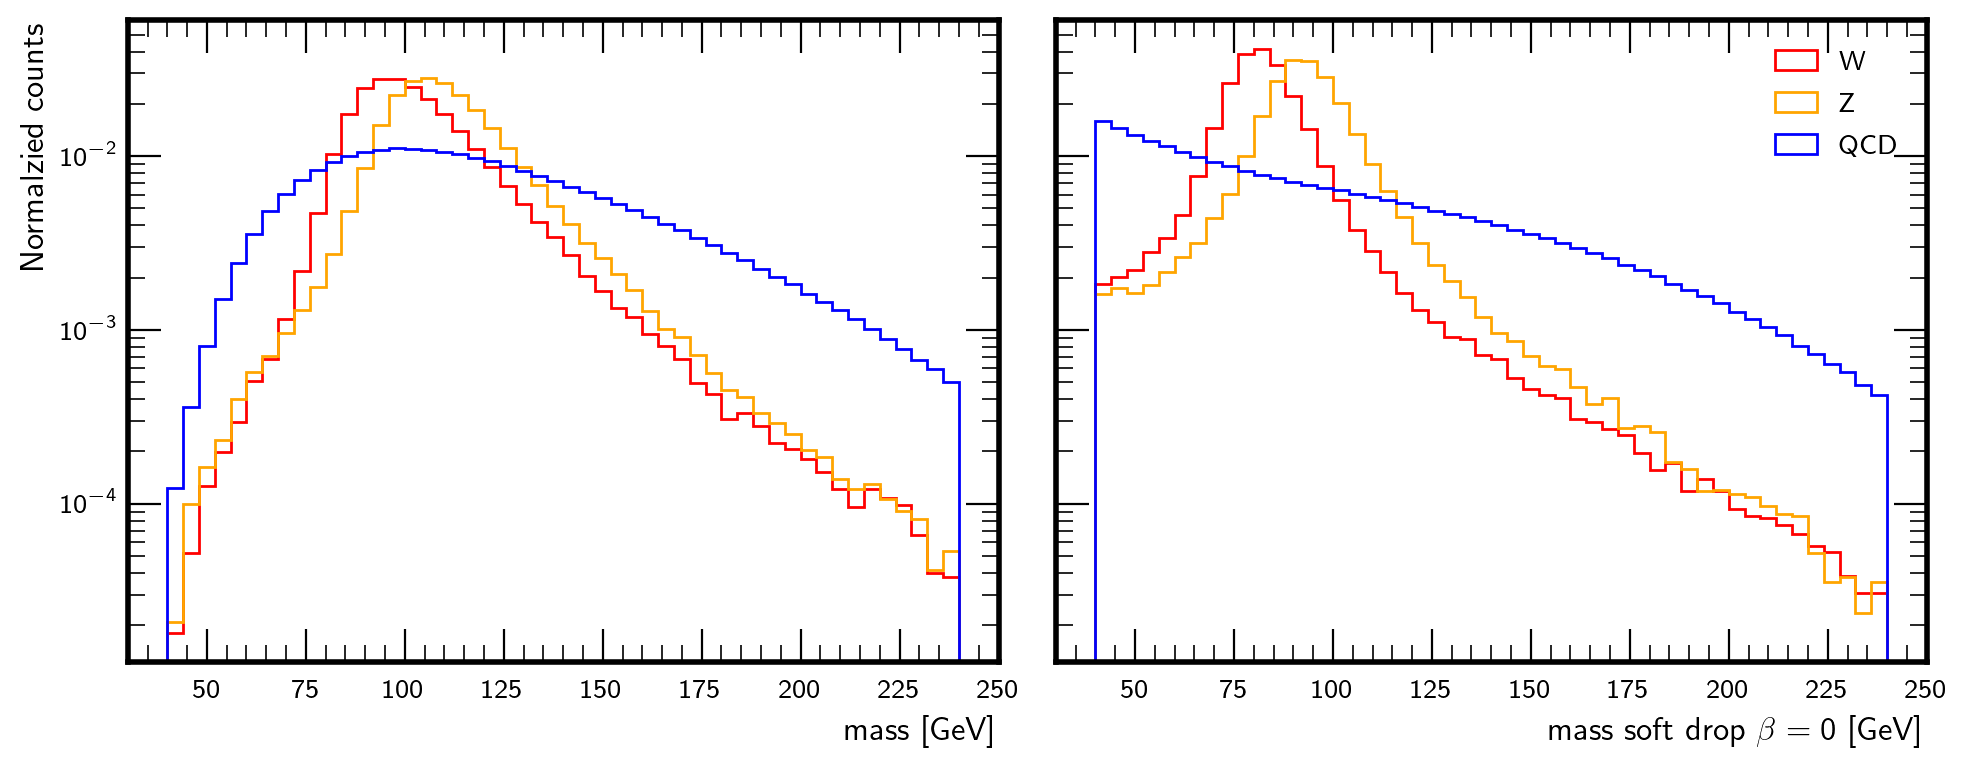

In [9]:
#plot
fig, (ax, ax1) = plt.subplots(1, 2, dpi=200, figsize=(10, 4), sharey=True)
kwargs = {"bins": 50, "range": (40, 240), "density": True, "histtype": "step"}
ax.hist(wqq13.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="r",
        label="W",
        **kwargs)
ax.hist(zqq13.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="orange",
        label="Z",
        **kwargs)
ax.hist(qcd.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="b",
        label="QCD",
        **kwargs)
ax.set_ylabel("Normalzied counts")
ax.set_xlabel("mass [GeV]")

ax1.hist(wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="r",
         label="W",
         **kwargs)
ax1.hist(zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="orange",
         label="Z",
         **kwargs)
ax1.hist(qcd.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="b",
         label="QCD",
         **kwargs)
ax1.legend(loc="upper right")
ax1.set_xlabel(r"mass soft drop $\beta=0$ [GeV]")
ax1.set_yscale("log")
fig.tight_layout()
plt.show()

What you observe is that the mass for our qcd background goes down to much lower values, and the mass for W boson gets more narrow and approaches the mass of the W boson (80.4 GeV).  This is a great way to reduce the background and improve the sensitivity of the signal. From now on, we will refer to the soft drop mass simply as mass.

### Preprocessing

In [10]:
labels = np.concatenate([np.zeros(len(z_samples)), np.ones(len(qcd_samples))])
combined_samples = np.concatenate([z_samples, qcd_samples],
                                  axis=0).astype("float32")
maxsamples = combined_samples.max(axis=0)
minsamples = combined_samples.min(axis=0)
combined_samples = (combined_samples - minsamples) / (maxsamples - minsamples)

qcd_samples = qcd_samples.astype("float32")
qcd_samples = (qcd_samples - minsamples) / (maxsamples - minsamples)
qcd_mass = qcd.arrays("vjet0_msd0", library="np")["vjet0_msd0"][qcdsel]
w_samples = w_samples.astype("float32")
w_samples = (w_samples - minsamples) / (maxsamples - minsamples)
w_mass = wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wsel]
z_samples = z_samples.astype("float32")
z_samples = (z_samples - minsamples) / (maxsamples - minsamples)
z_mass = zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zsel]
zz_samples = zz_samples.astype("float32")
zz_samples = (zz_samples - minsamples) / (maxsamples - minsamples)
zz_mass = zz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zzsel]
ww_samples = ww_samples.astype("float32")
ww_samples = (ww_samples - minsamples) / (maxsamples - minsamples)
ww_mass = ww.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wwsel]
wz_samples = wz_samples.astype("float32")
wz_samples = (wz_samples - minsamples) / (maxsamples - minsamples)
wz_mass = wz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wzsel]
tt_samples = tt_samples.astype("float32")
tt_samples = (tt_samples - minsamples) / (maxsamples - minsamples)
tt_mass = tt.arrays("vjet0_msd0", library="np")["vjet0_msd0"][ttsel]
ggh_samples = ggh_samples.astype("float32")
ggh_samples = (ggh_samples - minsamples) / (maxsamples - minsamples)
ggh_mass = ggh.arrays("vjet0_msd0", library="np")["vjet0_msd0"][gghsel]
data_samples = data_samples.astype("float32")
data_samples = (data_samples - minsamples) / (maxsamples - minsamples)
data_mass = data.arrays("vjet0_msd0", library="np")["vjet0_msd0"][datasel]
# Combined Sample mass
mass = np.concatenate([z_mass, qcd_mass]).astype("float32")
m = 2 * (mass - mass.min()) / (mass.max() - mass.min()) - 1

In [11]:
torch.random.manual_seed(42)
labels_ = labels  #[:10*len(sig)] #we could select a smaller subset here of qcd since we have way more QCD events
weights = np.zeros_like(labels_)
weights[labels_ == 0] = get_class_weights(labels_)[0]
weights[labels_ == 1] = get_class_weights(labels_)[1]
dataset = DataSet(samples=combined_samples,
                  labels=labels_,
                  weights=weights,
                  m=m)
traindataset, valdataset = torch.utils.data.random_split(
    dataset, [len(labels_) - len(z_samples),
              len(z_samples)])
trainloader = torch.utils.data.DataLoader(traindataset,
                                          num_workers=6,
                                          batch_size=4096,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataset,
                                        num_workers=6,
                                        batch_size=4096,
                                        shuffle=False)

#X = torch.from_numpy(samples[2*len(sig):,:]).float()#.to(device)

In [12]:
# Testing data and Plotting
test_mass = mass[valdataset.indices]
test_labels = dataset[valdataset.indices][1]
test = torch.from_numpy(dataset.samples[valdataset.indices])


def plot_hists(scores,
               test_mass=test_mass,
               test_labels=test_labels,
               c="w",
               label=None,
               lw=None,
               plot_path=None,
               dpi=200,
               show=False,
               transparent=None,
               density=True):
    cut = find_threshold(scores, (test_labels == 0), .5)
    # sig_bkg
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.6), dpi=dpi)
    w, bins = np.histogram(test_mass[test_labels == 1], bins=80, density=False)
    #plt.hist(bins[:-1],bins=bins,weights=w,histtype="step",label="Before selection",color="darkred",ls="-")
    false_signal = test_mass[(test_labels == 1) & (scores < cut)]
    w_bkg, bins = np.histogram(false_signal, bins=bins)
    true_signal = test_mass[(test_labels == 0) & (scores < cut)]
    w_sig, bins = np.histogram(true_signal, bins=bins)
    #     plt.hist(bins[:-1],bins=bins,weights=w_bkg,density=density,histtype="step",label=label.strip()+" bkg",color=c,lw=lw)
    #     plt.hist(bins[:-1],bins=bins,weights=w_sig,density=density,histtype="step",label=label.strip()+" sig",color="r",lw=lw)
    plt.hist(test_mass[(test_labels == 0) & (scores < cut)],
             bins=80,
             density=density,
             histtype="step",
             label="selected sig",
             color="r",
             lw=lw)
    plt.hist(test_mass[(test_labels == 1) & (scores < cut)],
             bins=80,
             density=density,
             histtype="step",
             label="selected bkg",
             color="b",
             lw=lw)
    plt.hist(test_mass[test_labels == 0],
             bins=80,
             density=density,
             histtype="step",
             label="Signal",
             color="r",
             ls="--",
             alpha=.75)
    plt.hist(test_mass[test_labels == 1],
             bins=80,
             density=density,
             histtype="step",
             label="Background",
             color="b",
             ls="--",
             alpha=.75)
    plt.legend(loc='upper right', fontsize=12, ncol=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([40, 240])
    #plt.ylim([2e-6,1e-1])
    plt.yscale("log")
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xlabel("Mass [GeV]", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    fig.tight_layout(pad=0)
    #plt.title("Distributions of Predicted Background")
    #plt.savefig(plot_path.format("selectedbkg_sans"))
    if plot_path is not None: plt.savefig(plot_path, transparent=transparent)
    #if show:
    #plt.show()
    #plt.close()
    return fig, ax


def plot_lines(scores,
               test_mass=test_mass,
               test_labels=test_labels,
               plot_path=None,
               show=False,
               mbins=100,
               histbins=None,
               dpi=200,
               ncuts=9,
               transparent=None,
               ptype=0,
               dynamicbins=True,
               scale=None,
               xlim=None,
               legend_ncol=3,
               cmap=plt.cm.viridis,
               ylim=[-0.02, 1.02]):
    if histbins == None:
        histbins = mbins

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), dpi=dpi)
    efficiencies = np.linspace(0.1, 0.9, ncuts)[::-1]
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(scores, (test_labels == 0), eff))
    m = test_mass[test_labels == 1]
    scores_ = scores[test_labels == 1]
    if dynamicbins:
        mod = len(test_mass) % mbins
        if mod != 0:
            m = m[:-mod]
            scores_ = scores_[:-mod]
        sorted_m = np.argsort(m)
        scores_ = scores_[sorted_m].reshape(mbins, -1)
        m = m[sorted_m]
        m = m.reshape(mbins, -1).mean(axis=1)
    else:
        _, bins = np.histogram(m, bins=mbins)
        digitized = np.digitize(m, bins)
        m = (bins[:-1] + bins[1:]) * 0.5
    for j, cut in enumerate(cuts):
        c = cmap(j / ncuts)  #f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores_ < cut).sum(axis=1) / scores_.shape[1]
        else:
            passed = [(scores_[digitized == i + 1] < cut).sum() /
                      (digitized == i + 1).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,
                     passed,
                     label="{:0.1f} ({:0.2f})".format(efficiencies[j], cut),
                     alpha=0.9,
                     c=c,
                     lw=1)
        else:
            ax1.step(m,
                     passed,
                     label="{:0.1f} ({:0.2f})".format(efficiencies[j], cut),
                     alpha=0.9,
                     c=c,
                     lw=1)
    if scale is not None:
        ax1.set_yscale(scale)
    ax1.set_ylabel("False Pos. Rate", fontsize=14)
    ax1.set_ylim(ylim)
    if xlim: ax1.set_xlim(xlim)
    if legend_ncol > 0:
        ax1.legend(loc='upper right',
                   bbox_to_anchor=(1, 1),
                   markerscale=5,
                   title="SE (Cut)",
                   ncol=legend_ncol,
                   fontsize=12)
    ax1.set_xlabel("Mass [GeV]", fontsize=14)
    fig.tight_layout(pad=0)
    if plot_path is not None:
        fig.savefig(plot_path, transparent=transparent)
    plt.show()
    return

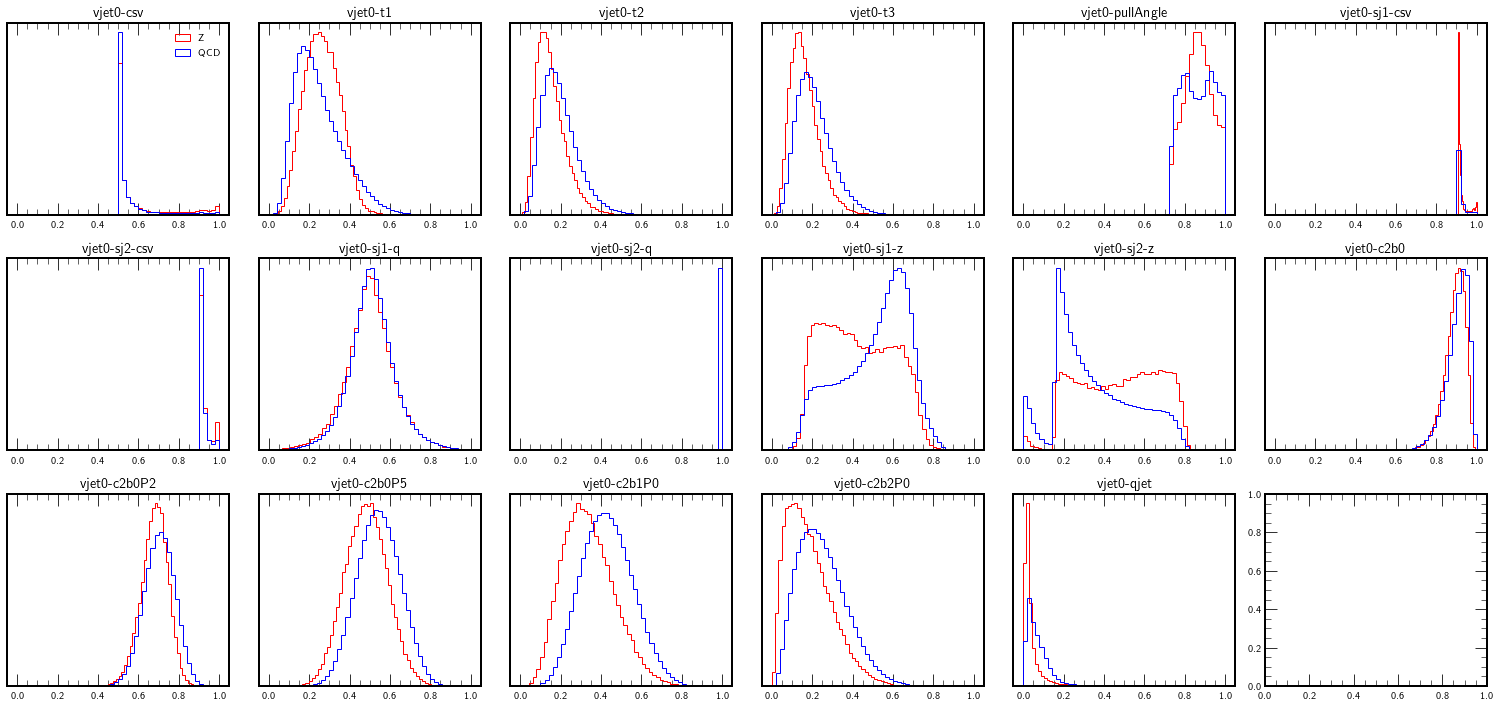

In [13]:
# plotting features
fig, axes = plt.subplots(3, 6, figsize=(21, 10))
kwargs = {"bins": 50, "density": True, "histtype": "step"}
for i, ax in enumerate(axes.flatten()):
    try:
        bkg_min = qcd_samples[:,i].min() if qcd_samples[:, i].min() > -10 else -1
        sig_min = z_samples[:, i].min() if w_samples[:, i].min() > -10 else -1
        ax.hist(z_samples[:, i],
                range=[sig_min, z_samples[:, i].max()],
                color="r",
                label='Z',
                **kwargs)
        ax.hist(qcd_samples[:, i],
                range=[bkg_min, qcd_samples[:, i].max()],
                color="b",
                label='QCD',
                **kwargs)
    except IndexError:
        continue
    ax.set_title("-".join(keys[i].split("_")))
    ax.set_yticks([])
    if i == 0: ax.legend()
    fig.tight_layout()

In [14]:
logdir = "./lightning_logs/Z-tag/4096/"
if not os.path.exists(logdir): os.makedirs(logdir, exist_ok=True)
with open(os.path.join(logdir, "features.txt"), "w") as f:
    f.writelines("\n".join(keys))
epochs = 30
lr = 1e-3
optim = torch.optim.Adam

# Unconstrained

In [15]:
# Train the NN 
module = MLP(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
model = Model(module, optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = ProgressBar()
log = Logger(logdir, name="unconstrained",default_hp_metric=False)
path = os.path.join(logdir,f"unconstrained/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(model,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/Z-tag/4096/unconstrained
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 9.6 K 


Epoch 29: 100%|##########| 584/584 [00:06<00:00, 83.86it/s, loss=0.148, v_num=0, val_loss=0.145, val_acc=0.83] 


1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


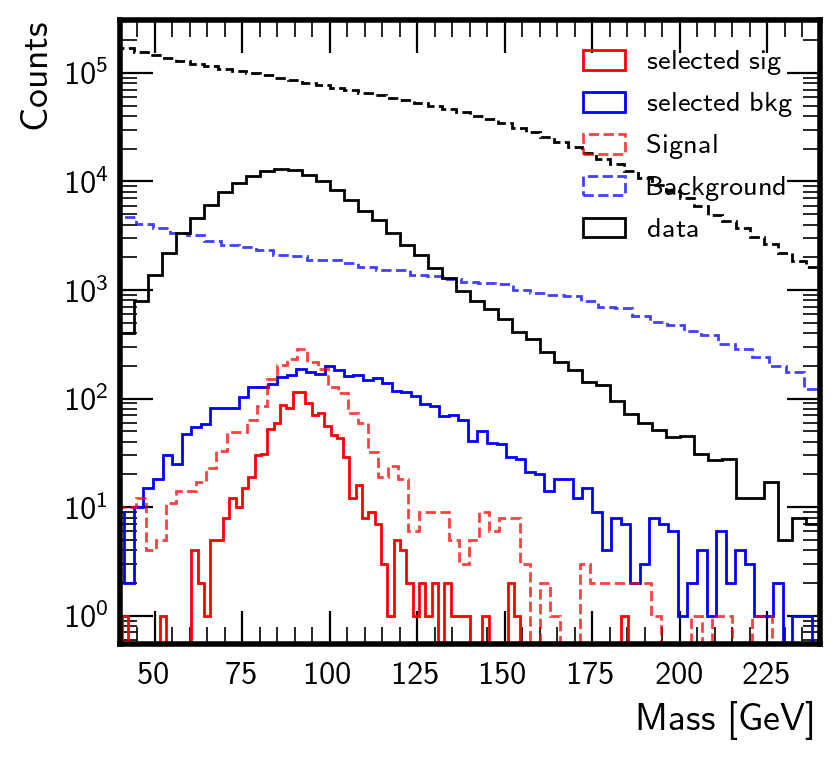

In [16]:
with torch.no_grad():
    module.eval()
    scores = torch.sigmoid(module(test)).numpy().flatten()
    data_scores = torch.sigmoid(module(torch.from_numpy(data_samples))).numpy().flatten()
fig, ax = plot_hists(scores,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
cut = find_threshold(scores,(test_labels==0),.5)
ax.hist(data_mass, histtype="step",color="k",bins=50,range=(40,240),density=False,ls="--")
ax.hist(data_mass[data_scores<cut], histtype="step",color="k",bins=50,range=(40,240),density=False, label="data")
plt.legend()
plt.show()

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encoun

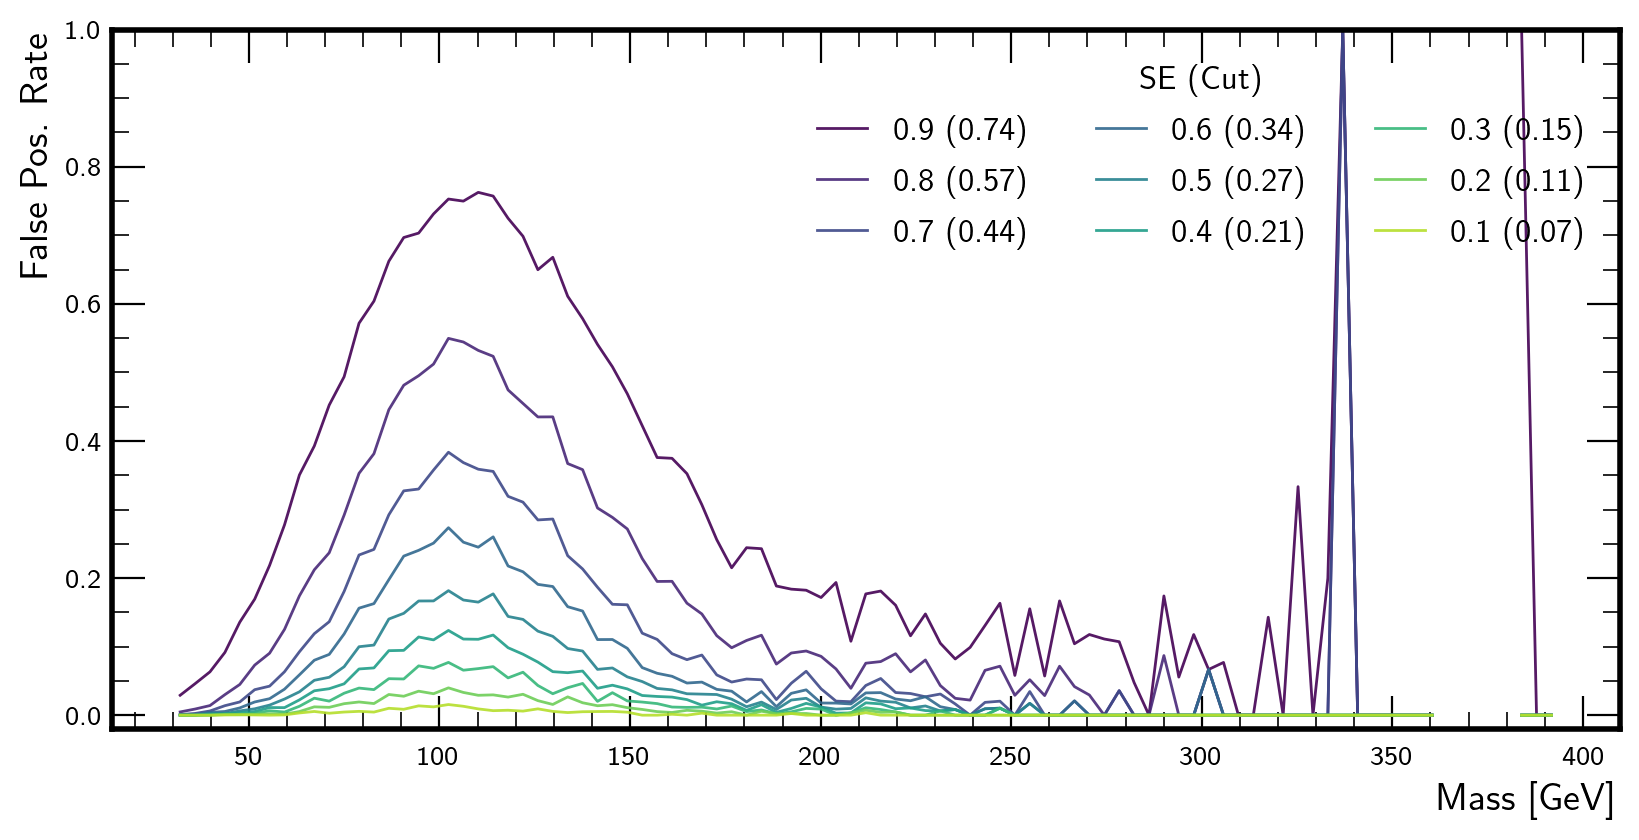

In [17]:
plot_lines(scores,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale=None,xlim=None,ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

0.55137116


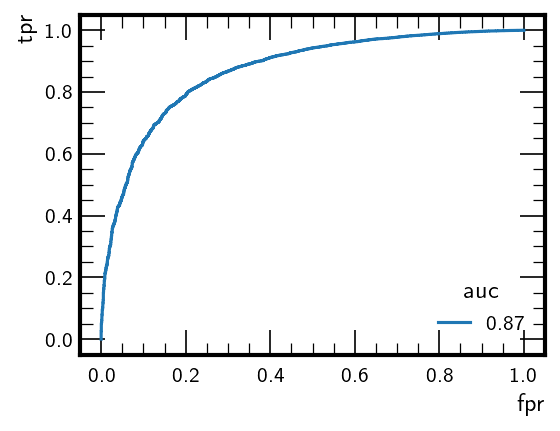

In [18]:
auc = roc_auc_score(y_score=scores, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
print(cuts[(tpr-fpr).argmax()])
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# MoDe

In [19]:
mode0 = MoDeLoss(bins=32,
    sbins=32,
    memory=False,
    background_label=1,
    background_only=True,
    power=2,
    order=0,
    lambd=None,
    max_slope=None,
    monotonic=False,
    eps=0.0001,
    dynamicbins=True,
    normalize=True,
    sign_func='tanh')

In [20]:
# Train the NN 
module0 = MLP(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
model = Model(module0, optim=optim(module0.parameters(),lr=lr), regularization=50, regularizer = mode0)
# Run
pl.seed_everything(42)
bar = ProgressBar()
log = Logger(logdir, name="mode0",default_hp_metric=False)
path = os.path.join(logdir,f"mode0/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(model,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/Z-tag/4096/mode0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 9.6 K 


Epoch 29: 100%|##########| 584/584 [00:09<00:00, 63.50it/s, loss=0.236, v_num=0, val_loss=0.198, val_acc=0.87, val_loss_reg=0.0198] 


1

(<Figure size 800x720 with 1 Axes>,
 <AxesSubplot:xlabel='Mass [GeV]', ylabel='Counts'>)

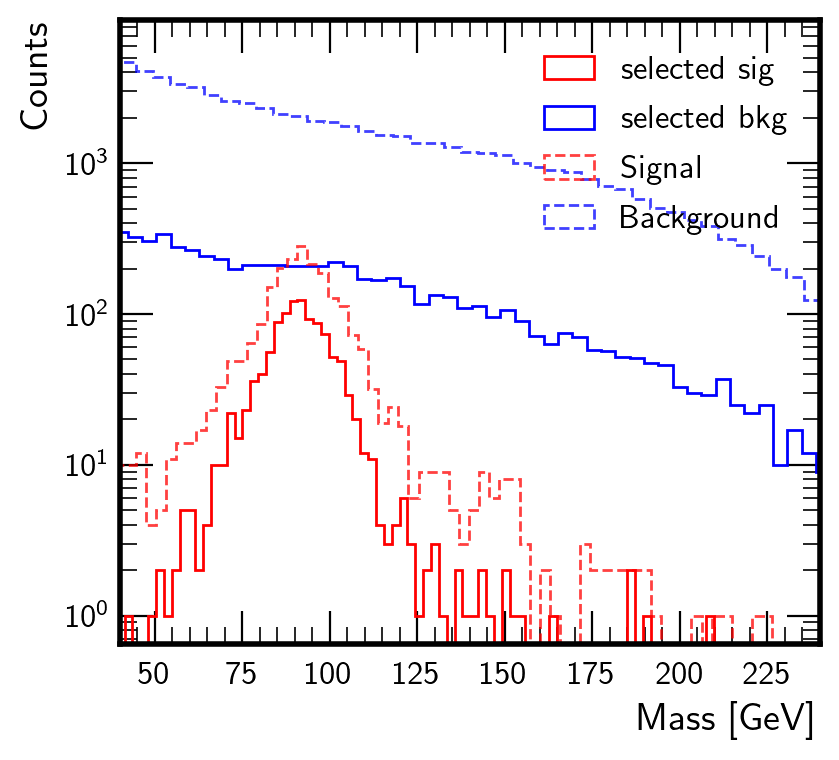

In [21]:
with torch.no_grad():
    module0.eval()
    scores0 = torch.sigmoid(module0(test)).numpy().flatten()
cmap = plt.cm.coolwarm
plot_hists(scores0,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
# plot_lines(scores,show=True,mbins=100,histbins=None,ncuts=13,dpi=200,transparent=False,
#        ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=0,cmap=cmap)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encoun

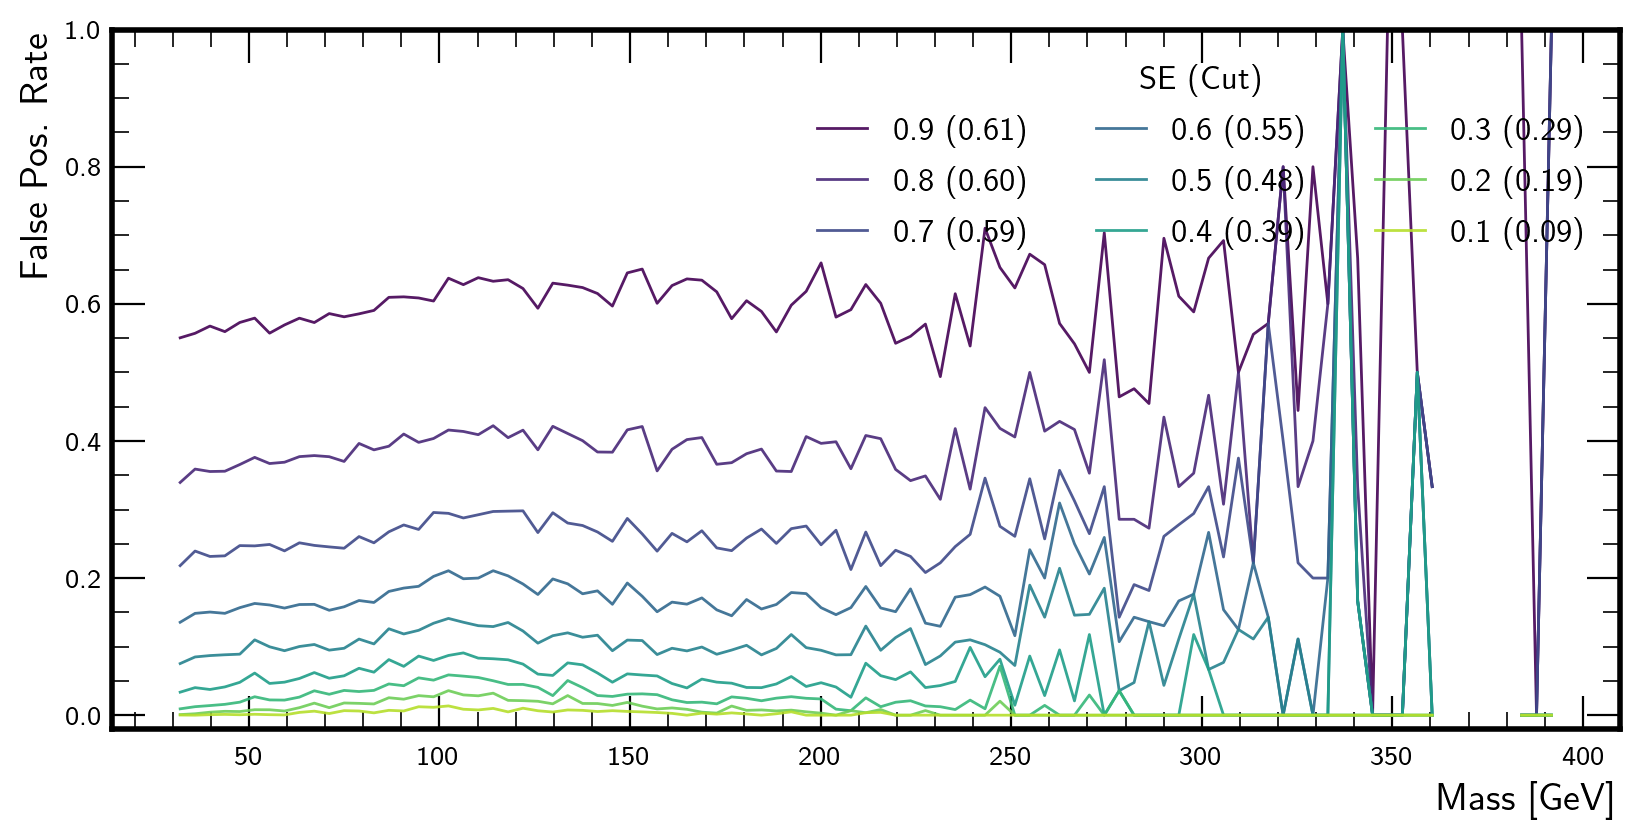

In [22]:
plot_lines(scores0,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale="linear",xlim=None, ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

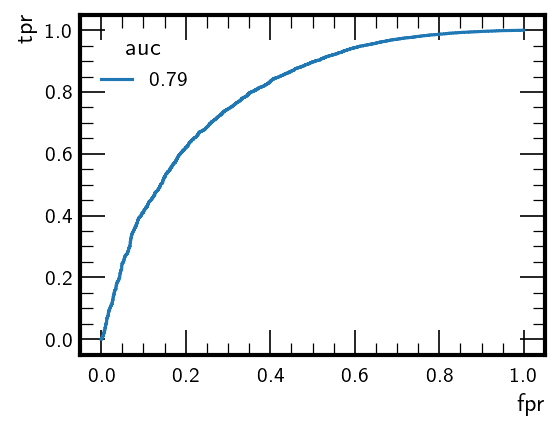

In [23]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores0, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores0, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# DisCo

In [24]:
# Train the NN 
disco_loss = DiscoLoss(background_only=True, background_label=1, power=1)
module_disco = MLP(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
model = Model(module_disco, optim=optim(module_disco.parameters(),lr=lr), regularization=20, regularizer = disco_loss)
# Run
pl.seed_everything(42)
bar = ProgressBar()
log = Logger(logdir, name="disco",default_hp_metric=False)
path = os.path.join(logdir,f"disco/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(model,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/Z-tag/4096/disco
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 9.6 K 


Epoch 29: 100%|##########| 584/584 [00:17<00:00, 32.89it/s, loss=0.216, v_num=0, val_loss=0.189, val_acc=0.68, val_loss_reg=0.0195] 


1

(<Figure size 800x720 with 1 Axes>,
 <AxesSubplot:xlabel='Mass [GeV]', ylabel='Counts'>)

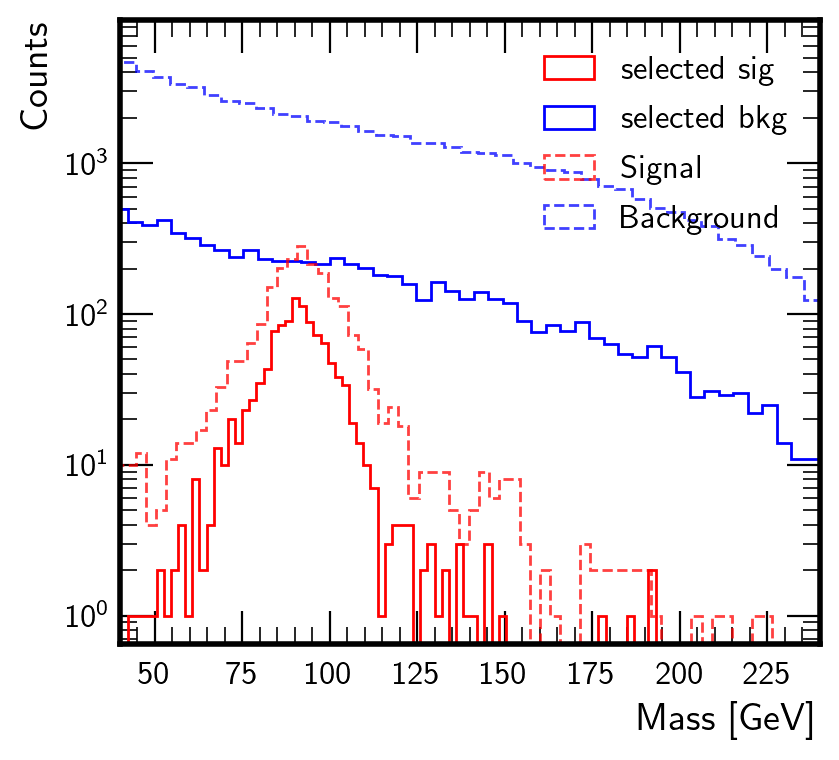

In [25]:
with torch.no_grad():
    module_disco.eval()
    scores_disco = torch.sigmoid(module_disco(test)).numpy().flatten()
cmap = plt.cm.coolwarm
plot_hists(scores_disco,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
# plot_lines(scores,show=True,mbins=100,histbins=None,ncuts=13,dpi=200,transparent=False,
#        ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=0,cmap=cmap)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encoun

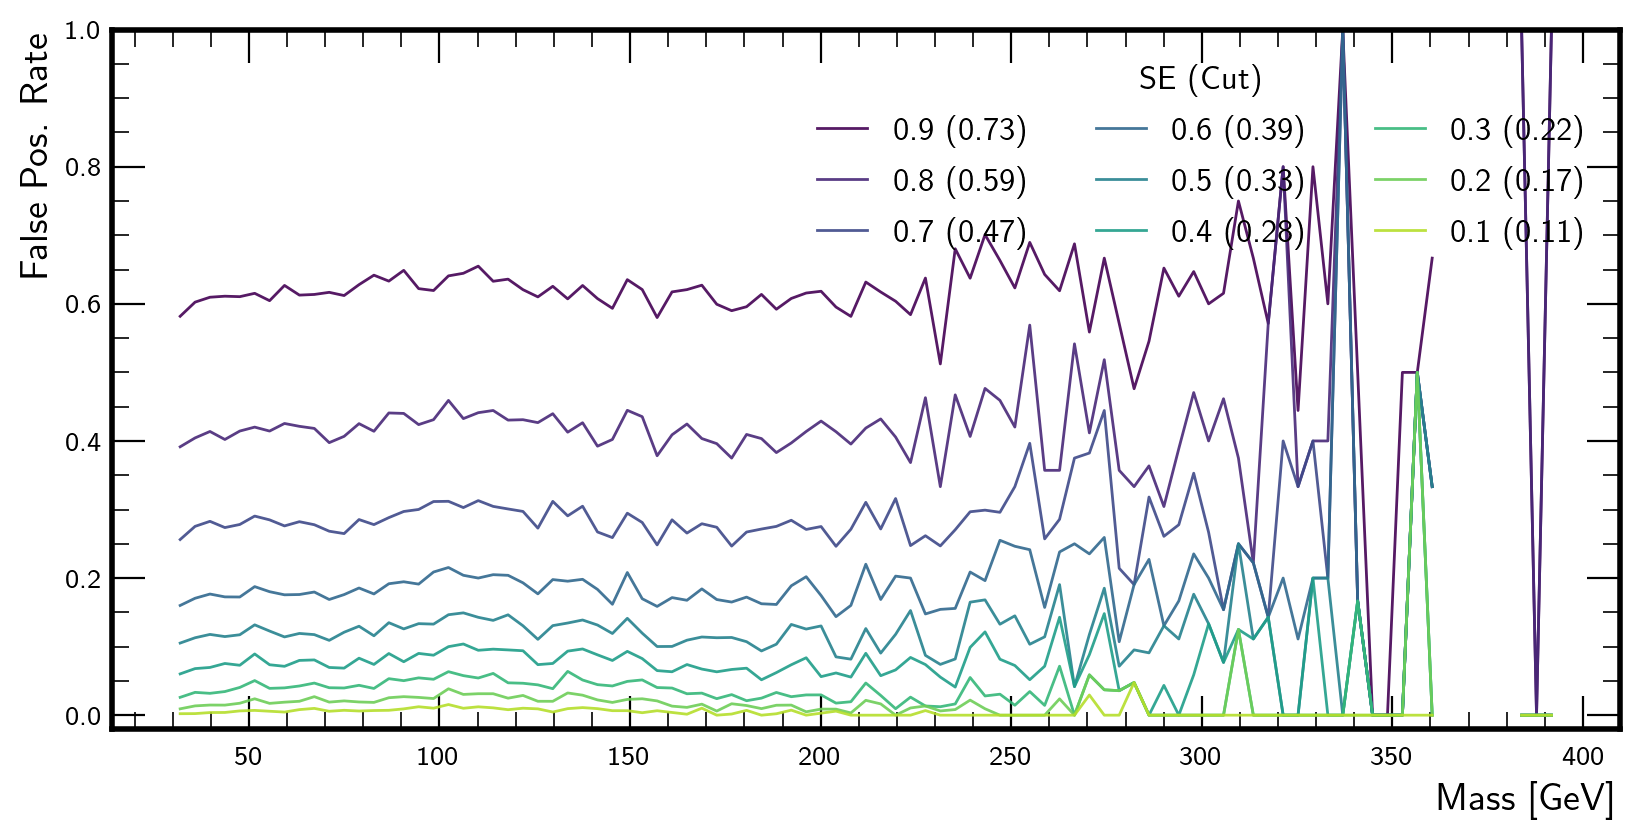

In [26]:
plot_lines(scores_disco,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale="linear",xlim=None, ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

0.55137116


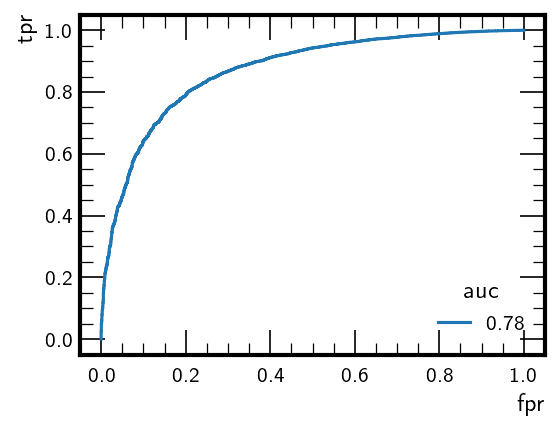

In [27]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores_disco, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
print(cuts[(tpr-fpr).argmax()])
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# Fitting 

In [28]:
#define a polynomial with a guassian note polyval is a pre-coded polynomial
def polgaus(x, p0, p1, p2, p3, a, mu, sigma):
    pols=[p0, p1, p2, p3,]
    #legendre_poly = np.polynomial.Legendre(pols)
    poly  = np.polyval(pols,x)
#     exp   = np.exp(-lambd*x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss #+ b*exp
    return y

#define just a polynomial
def polback(x, p0, p1, p2, p3 ):
    pols=[p0,p1,p2,p3]
    y = np.polyval(pols,x)
    return y

In [29]:
import lmfit as lm

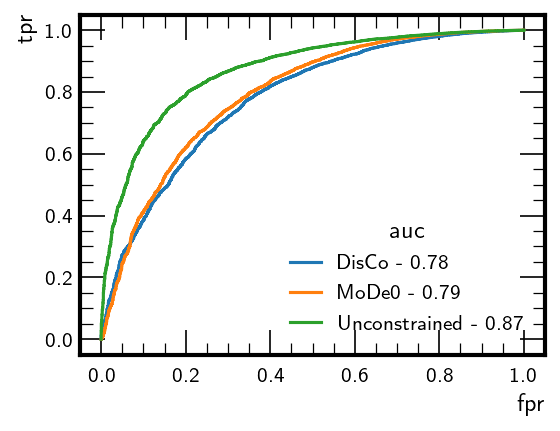

In [30]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores_disco, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores_disco, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"DisCo - {auc:.2f}")
auc = roc_auc_score(y_score=scores0, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores0, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"MoDe0 - {auc:.2f}")
auc = roc_auc_score(y_score=scores, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"Unconstrained - {auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

0.58270013


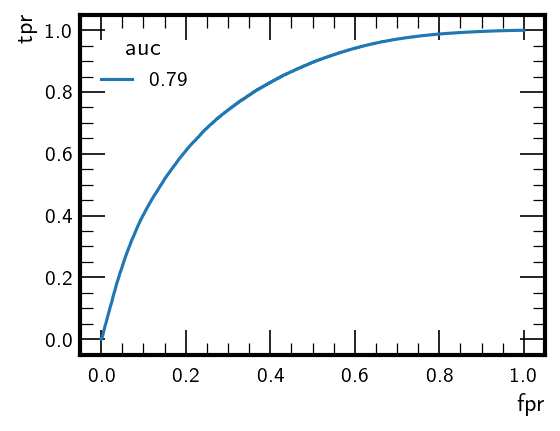

In [31]:
# get scores
with torch.no_grad():
    module0.eval()
    qcd_scores = torch.sigmoid(module0(torch.from_numpy(qcd_samples))).numpy().flatten()
    w_scores = torch.sigmoid(module0(torch.from_numpy(w_samples))).numpy().flatten()
    data_scores = torch.sigmoid(module0(torch.from_numpy(data_samples))).numpy().flatten()
    z_scores = torch.sigmoid(module0(torch.from_numpy(z_samples))).numpy().flatten()
    zz_scores = torch.sigmoid(module0(torch.from_numpy(zz_samples))).numpy().flatten()
    wz_scores = torch.sigmoid(module0(torch.from_numpy(wz_samples))).numpy().flatten()
    ww_scores = torch.sigmoid(module0(torch.from_numpy(ww_samples))).numpy().flatten()
    tt_scores = torch.sigmoid(module0(torch.from_numpy(tt_samples))).numpy().flatten()
    ggh_scores = torch.sigmoid(module0(torch.from_numpy(ggh_samples))).numpy().flatten()
combined_scores = np.concatenate([z_scores,qcd_scores])
auc = roc_auc_score(y_score=combined_scores, y_true=labels)
fpr, tpr, cuts = roc_curve(y_score=combined_scores, y_true=labels)
print(cuts[(tpr-fpr).argmax()])
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

Scale: 1.6836067433254933 14748.133987809199 8759.844925946538
Scale: 0.6932541250123121 5663.988480165775 8170.147534376638


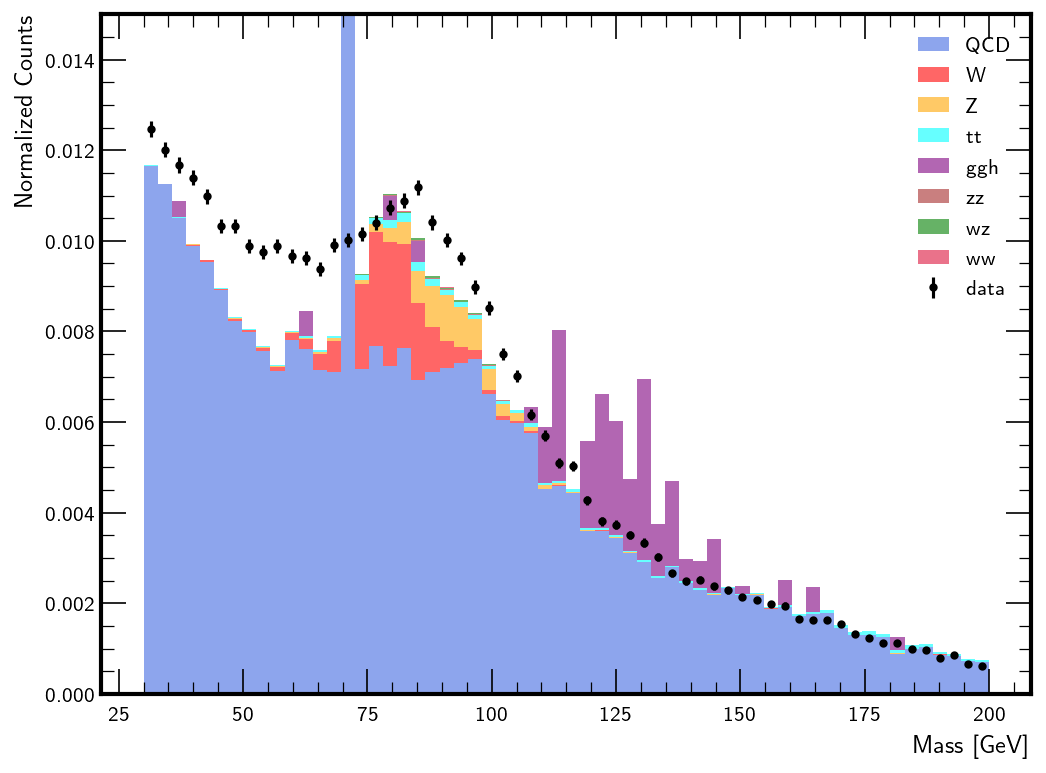

In [32]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
density = True
mrange, bins = (30,200), 60
cut = .44

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)


# qcd_mask = np.zeros(len(data))
# qcd_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==1)]] = 1
# w_mask = np.zeros(len(data))
# w_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==0)]] = 1
qcd_mask = (qcd_scores<cut)
w_mask = (w_scores<cut)
z_mask = (z_scores<cut)
data_mask = (data_scores<cut)
ww_mask = (ww_scores<cut)
wz_mask = (wz_scores<cut)
zz_mask = (zz_scores<cut)
tt_mask = (tt_scores<cut)
ggh_mask = (ggh_scores<cut)

hist_weights = [get_weights(weights,qcd,qcdsel)[qcd_mask],
                get_weights(weights,wqq13,wsel)[w_mask]*wscale,
                get_weights(weights,zqq13,zsel)[z_mask]*zscale,
                get_weights(weights,tt,ttsel)[tt_mask],
                get_weights(weights,ggh,gghsel)[ggh_mask],
                get_weights(weights,zz,zzsel)[zz_mask],
                get_weights(weights,wz,wzsel)[wz_mask],
                get_weights(weights,ww,wwsel)[ww_mask],
               ]
hists = [qcd_mass[qcd_mask],
         w_mass[w_mask],
         z_mass[z_mask],
         tt_mass[tt_mask],
         ggh_mass[ggh_mask],
         zz_mass[zz_mask],
         wz_mass[wz_mask],
         ww_mass[ww_mask],
        ]
plot_labels = ["QCD", "W", "Z", "tt", "ggh", "zz", "wz", "ww"]
plot_colors = ["royalblue",'r',"orange", "cyan", "purple", "brown", "green", "crimson"]
# plt.hist(all_mass[(scores<cut)&(all_labels==0)], bins=bins, range=mrange, alpha=0.6, label="W")
# plt.hist(all_mass[(scores<cut)&(all_labels==1)], bins=bins, range=mrange, alpha=0.6, label="QCD")
fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=150)
_,bins,_ = plt.hist(hists,
         color=plot_colors, label=plot_labels, weights=hist_weights,
         range=mrange, bins=bins, alpha=.6, density=density,stacked=True)
counts, _ = np.histogram(data_mass[data_mask],bins=bins,density=density)
yerr = np.sqrt(counts) 
if density: yerr /= np.sqrt(sum(data_mask)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data", ms=3)

plt.ylim(0,0.015)
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 194
    # data points      = 60
    # variables        = 7
    chi-square         = 1499.9741
    reduced chi-square = 28.3013985
    Akaike info crit   = 207.131514
    Bayesian info crit = 221.791926
[[Variables]]
    p0:     1.4909e-09 +/- 1.2206e-09 (81.87%) (init = -1.3886e-12)
    p1:    -5.4063e-07 +/- 4.6286e-07 (85.62%) (init = 1.8024e-09)
    p2:     5.7001e-05 +/- 5.3328e-05 (93.56%) (init = -5.2497e-07)
    p3:    -0.00174547 +/- 0.00177192 (101.52%) (init = 7.3652e-05)
    a:      0.00258421 +/- 8.2194e-04 (31.81%) (init = 1)
    mu:     84.9415774 +/- 1.89337216 (2.23%) (init = 80)
    sigma:  5.38649208 +/- 2.06649083 (38.36%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.995
    C(p1, p2)    = -0.992
    C(p0, p2)    =  0.975
    C(p2, p3)    = -0.973
    C(p1, p3)    =  0.938
    C(p0, p3)    = -0.907
    C(a, sigma)  = -

1499.9741

<Figure size 720x720 with 0 Axes>

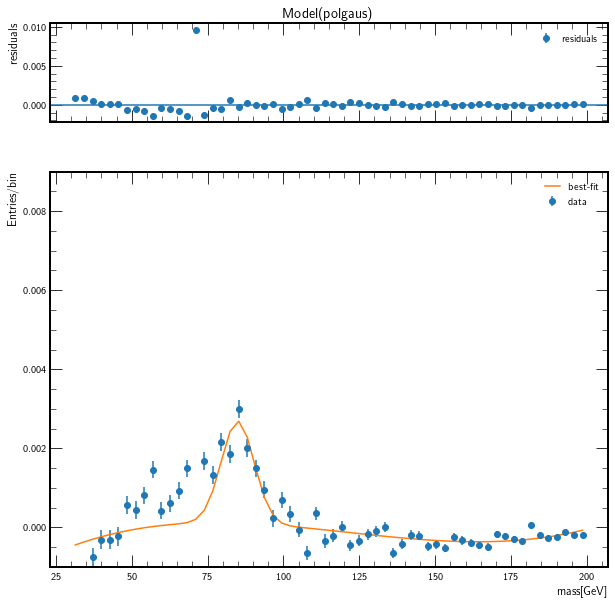

In [33]:
qcdweights = get_weights(weights,qcd,qcdsel)[qcd_mask]
zweights = get_weights(weights,zqq13,zsel)[z_mask]*zscale
counts_data, bins = np.histogram(data_mass[data_mask],bins=bins,range=mrange, density=True)
counts_qcd, bins = np.histogram(mass[(combined_scores<cut)&(labels==1)],bins=bins, density=True, weights=qcdweights)
counts = counts_data - counts_qcd
yvar = counts_data/sum(data_mask)/(bins[1]-bins[0]) + counts_qcd/sum(qcdweights)/(bins[1]-bins[0]) #+ counts_z/sum(zweights)/(bins[1]-bins[0])
w = 1/np.sqrt(abs(yvar))
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")


model = lm.Model(polgaus)
p = model.make_params(p0=-1.3886e-12,p1=1.8024e-09,p2=-5.2497e-07,
                      p3=7.3652e-05,p4=-0.00503250,p5=0.14118380,
                      a=1,mu=80,sigma=2.5)
p["mu"].max = 200
p["mu"].min = 40
p["mu"].vary = True
p["sigma"].max = 0
p["sigma"].min = 10

result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
plt.ylim([-.001,.009])
print(result.fit_report())
result.chisqr

0.4389429


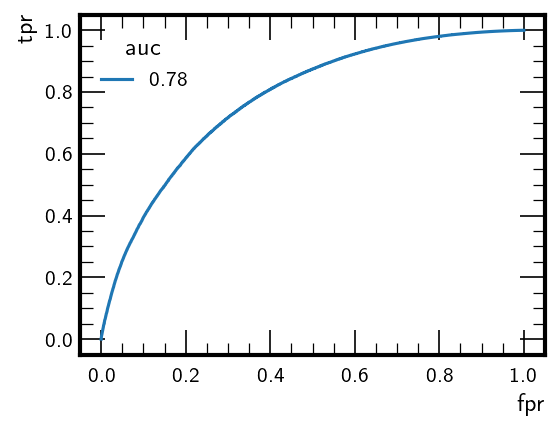

In [34]:
# get scores
with torch.no_grad():
    module_disco.eval()
    qcd_scores = torch.sigmoid(module_disco(torch.from_numpy(qcd_samples))).numpy().flatten()
    w_scores = torch.sigmoid(module_disco(torch.from_numpy(w_samples))).numpy().flatten()
    data_scores = torch.sigmoid(module_disco(torch.from_numpy(data_samples))).numpy().flatten()
    z_scores = torch.sigmoid(module_disco(torch.from_numpy(z_samples))).numpy().flatten()
    zz_scores = torch.sigmoid(module_disco(torch.from_numpy(zz_samples))).numpy().flatten()
    wz_scores = torch.sigmoid(module_disco(torch.from_numpy(wz_samples))).numpy().flatten()
    ww_scores = torch.sigmoid(module_disco(torch.from_numpy(ww_samples))).numpy().flatten()
    tt_scores = torch.sigmoid(module_disco(torch.from_numpy(tt_samples))).numpy().flatten()
    ggh_scores = torch.sigmoid(module_disco(torch.from_numpy(ggh_samples))).numpy().flatten()
combined_scores = np.concatenate([z_scores,qcd_scores])
auc = roc_auc_score(y_score=combined_scores, y_true=labels)
fpr, tpr, cuts = roc_curve(y_score=combined_scores, y_true=labels)
print(cuts[(tpr-fpr).argmax()])
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

Scale: 1.6836067433254933 14748.133987809199 8759.844925946538
Scale: 0.6932541250123121 5663.988480165775 8170.147534376638


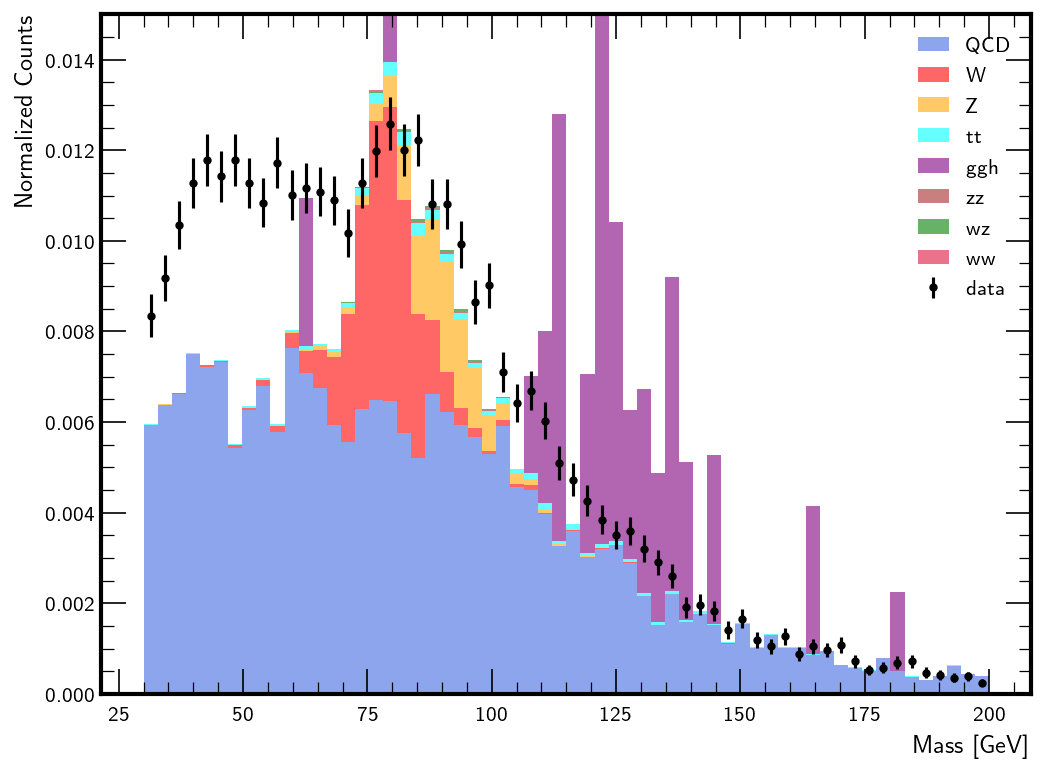

In [35]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
density = True
mrange, bins = (30,200), 60
cut = .14

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)


# qcd_mask = np.zeros(len(data))
# qcd_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==1)]] = 1
# w_mask = np.zeros(len(data))
# w_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==0)]] = 1
qcd_mask = (qcd_scores<cut)
w_mask = (w_scores<cut)
z_mask = (z_scores<cut)
data_mask = (data_scores<cut)
ww_mask = (ww_scores<cut)
wz_mask = (wz_scores<cut)
zz_mask = (zz_scores<cut)
tt_mask = (tt_scores<cut)
ggh_mask = (ggh_scores<cut)

hist_weights = [get_weights(weights,qcd,qcdsel)[qcd_mask],
                get_weights(weights,wqq13,wsel)[w_mask]*wscale,
                get_weights(weights,zqq13,zsel)[z_mask]*zscale,
                get_weights(weights,tt,ttsel)[tt_mask],
                get_weights(weights,ggh,gghsel)[ggh_mask],
                get_weights(weights,zz,zzsel)[zz_mask],
                get_weights(weights,wz,wzsel)[wz_mask],
                get_weights(weights,ww,wwsel)[ww_mask],
               ]
hists = [qcd_mass[qcd_mask],
         w_mass[w_mask],
         z_mass[z_mask],
         tt_mass[tt_mask],
         ggh_mass[ggh_mask],
         zz_mass[zz_mask],
         wz_mass[wz_mask],
         ww_mass[ww_mask],
        ]
plot_labels = ["QCD", "W", "Z", "tt", "ggh", "zz", "wz", "ww"]
plot_colors = ["royalblue",'r',"orange", "cyan", "purple", "brown", "green", "crimson"]
# plt.hist(all_mass[(scores<cut)&(all_labels==0)], bins=bins, range=mrange, alpha=0.6, label="W")
# plt.hist(all_mass[(scores<cut)&(all_labels==1)], bins=bins, range=mrange, alpha=0.6, label="QCD")
fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=150)
_,bins,_ = plt.hist(hists,
         color=plot_colors, label=plot_labels, weights=hist_weights,
         range=mrange, bins=bins, alpha=.6, density=density,stacked=True)
counts, _ = np.histogram(data_mass[data_mask],bins=bins,density=density)
yerr = np.sqrt(counts) 
if density: yerr /= np.sqrt(sum(data_mask)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data", ms=3)
# plt.hist(datat21, range=mrange,
#          bins=50, color='k',label="data", alpha=.6, density=density)
# plt.hist(wt21, weights=get_weights(wqq13,weights,wsel)*wscale, range=mrange,
#          bins=50, color='red',label="W", alpha=.6, density=density)
# plt.hist(zt21, weights=get_weights(zqq13,weights,zsel)*zscale, range=mrange,
#          bins=50, color='blue',label="Z", alpha=.6, density=density)
# plt.hist(ht21, weights=get_weights(ggh,weights,hsel),
#          bins=50, color='black',label="H", alpha=.6, density=True)
plt.ylim(0,0.015)
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 60
    # variables        = 7
    chi-square         = 123.77832
    reduced chi-square = 2.33544001
    Akaike info crit   = 57.4488598
    Bayesian info crit = 72.1092718
[[Variables]]
    p0:    -6.6369e-10 +/- 1.0371e-09 (156.26%) (init = -1.3886e-12)
    p1:     3.2764e-07 +/- 3.9532e-07 (120.66%) (init = 1.8024e-09)
    p2:    -4.7933e-05 +/- 4.5337e-05 (94.58%) (init = -5.2497e-07)
    p3:     0.00156594 +/- 0.00146162 (93.34%) (init = 7.3652e-05)
    a:      0.00315296 +/- 6.4484e-04 (20.45%) (init = 1)
    mu:     80.8658062 +/- 1.80826428 (2.24%) (init = 80)
    sigma:  8.32208842 +/- 2.05864572 (24.74%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.996
    C(p1, p2)    = -0.991
    C(p0, p2)    =  0.976
    C(p2, p3)    = -0.963
    C(p1, p3)    =  0.923
    C(p0, p3)    = -0.892
    C(p0, sigma) = -

123.77832

<Figure size 720x720 with 0 Axes>

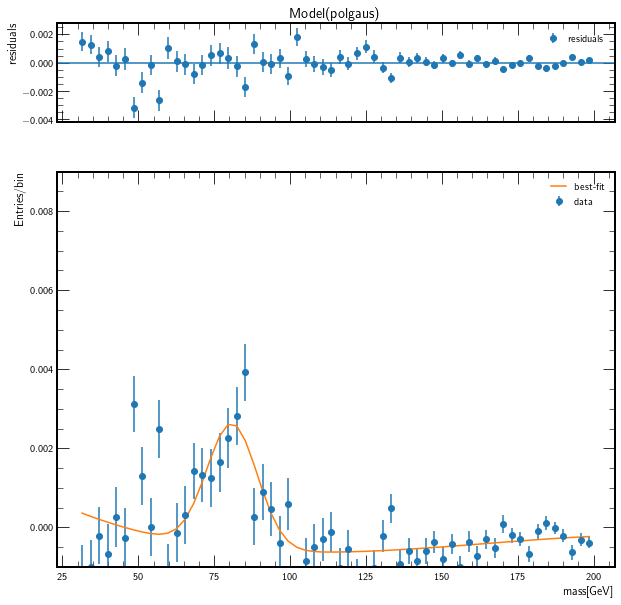

In [36]:
bins = bins
qcdweights = get_weights(weights,qcd,qcdsel)[qcd_mask]
zweights = get_weights(weights,zqq13,zsel)[z_mask]*zscale
counts_data, bins = np.histogram(data_mass[data_mask],bins=bins,range=mrange, density=True)
counts_qcd, bins = np.histogram(mass[(combined_scores<cut)&(labels==1)],bins=bins, density=True, weights=qcdweights)
counts = counts_data - counts_qcd
yvar = counts_data/sum(data_mask)/(bins[1]-bins[0]) + counts_qcd/sum(qcdweights)/(bins[1]-bins[0]) #+ counts_z/sum(zweights)/(bins[1]-bins[0])
w = 1/np.sqrt(abs(yvar))
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

model = lm.Model(polgaus)
p = model.make_params(p0=-1.3886e-12,p1=1.8024e-09,p2=-5.2497e-07,
                      p3=7.3652e-05,p4=-0.00503250,p5=0.14118380,
                      a=1,mu=80,sigma=2.5)
p["mu"].max = 200
p["mu"].min = 40
p["mu"].vary = True
p["sigma"].max = 0
p["sigma"].min = 10

result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
plt.ylim([-.001,.009])
print(result.fit_report())
result.chisqr